# Load data from kagglehub

In [9]:
import kagglehub

In [10]:
path = kagglehub.dataset_download("kamilpytlak/personal-key-indicators-of-heart-disease")

# Initiate Spark session

In [11]:
print(path)

/kaggle/input/personal-key-indicators-of-heart-disease


In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, when, round, count
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()
import matplotlib.pyplot as plt
from functools import reduce


In [13]:
df = spark.read.csv(path+"/2022/heart_2022_no_nans.csv", header=True, inferSchema=True)

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

Προβολή των στηλών του αρχείου και των διακριτών τιμών της κάθε μιας

In [14]:
df.columns

['State',
 'Sex',
 'GeneralHealth',
 'PhysicalHealthDays',
 'MentalHealthDays',
 'LastCheckupTime',
 'PhysicalActivities',
 'SleepHours',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'HeightInMeters',
 'WeightInKilograms',
 'BMI',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [15]:
for column in df.columns:
    print(f"Column: {column}")
    df.groupBy(column).count().orderBy("count", ascending=False).show(truncate=False)


Column: State
+--------------+-----+
|State         |count|
+--------------+-----+
|Washington    |15000|
|Maryland      |9165 |
|Minnesota     |9161 |
|Ohio          |8995 |
|New York      |8923 |
|Texas         |7408 |
|Florida       |7315 |
|Kansas        |6145 |
|Wisconsin     |6126 |
|Maine         |6013 |
|Iowa          |5672 |
|Hawaii        |5596 |
|Virginia      |5565 |
|Indiana       |5502 |
|South Carolina|5471 |
|Massachusetts |5465 |
|Arizona       |5462 |
|Utah          |5373 |
|Michigan      |5370 |
|Colorado      |5159 |
+--------------+-----+
only showing top 20 rows

Column: Sex
+------+------+
|Sex   |count |
+------+------+
|Female|127811|
|Male  |118211|
+------+------+

Column: GeneralHealth
+-------------+-----+
|GeneralHealth|count|
+-------------+-----+
|Very good    |86999|
|Good         |77409|
|Excellent    |41525|
|Fair         |30659|
|Poor         |9430 |
+-------------+-----+

Column: PhysicalHealthDays
+------------------+------+
|PhysicalHealthDays|cou

 Σύνδεση μεταξύ ωρών ύπνου και ιστορικού ανακοπής:
 - Καθώς οι απαντήσεις στην ερώτηση "πόσες ώρες κοιμάστε" μπορούν να είναι μέχρι 24, θα πρέπει να δούμε την κατανομή των απαντήσεων ώστε να σπάσουμε σε μπάντες το πόσες ώρες κοιμάται ο ερωτηθής. Η αρχική προσέγγιση στην οποία υπολογίζοταν ο μέσος όρος ωρών ύπνου για το δίτιμο ναι/όχι της στήλης HadHeartAttack βγαινει περίπου 7, δεν παίρνουμε σαφή απάντηση στο ερώτημα. Βλέποντας την κατανομή συνειδητοποιούμε ότι όντως, οι περισσότεροι κοιμούνται 7 εως 9 ώρες. Δεδομένου ότι το ιδανικό θεωρείται 8 ώρες ύπνου, και με βάση τις ακραίες τιμές στο άνω τμήμα της κατανομής (εως 24 ώρες!), σπάμε σε <7, 7-9,9-12 και >12, κυρίως λόγω πολλών απαντήσεων στο φάσμα 9-12, κάτι που δεν μας επιτρέπει να συγχωνεύσουμε τις 2 μπάντες 9-12 και >12 σε μια.

In [16]:
# multivariate plot function
def plotFunc(df, column: str):
    # Count occurrences
    dist_df = df.groupBy(column).count().orderBy(column)

    # Convert to pandas
    dist_pd = dist_df.toPandas()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(dist_pd[column], dist_pd["count"])
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title(f"Distribution of {column}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45 if dist_pd[column].dtype == object else 0)
    plt.tight_layout()
    plt.show()



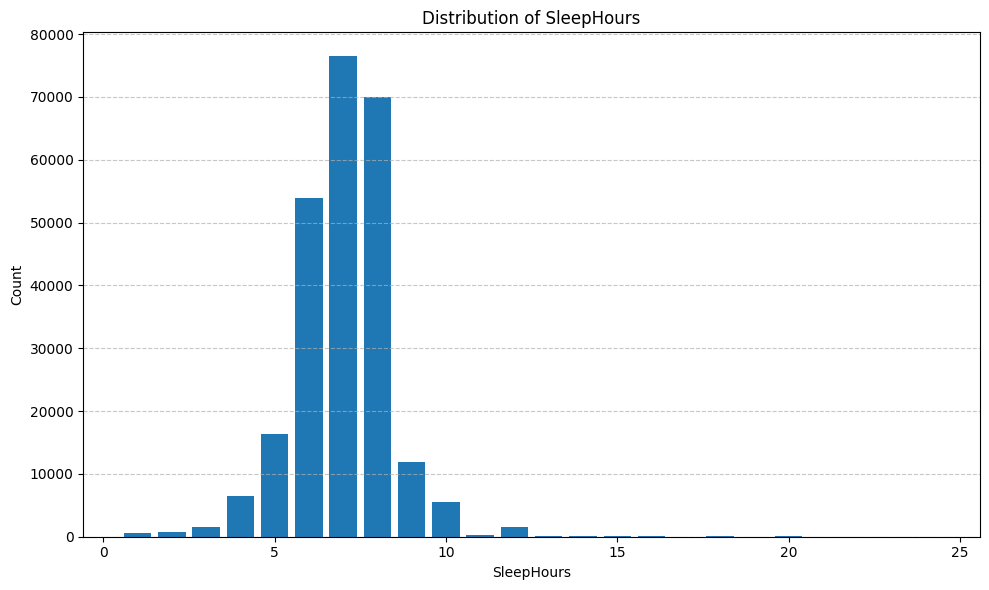

In [17]:
# sleep hours distribution
plotFunc(df, "SleepHours")

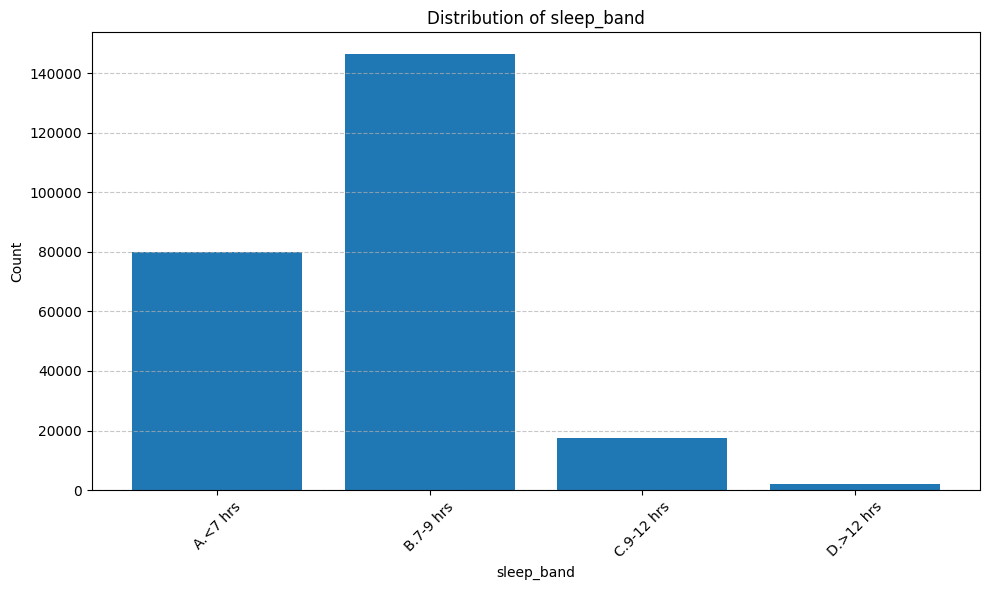

In [18]:
df = df.withColumn(
    "sleep_band",
    when(col("SleepHours") < 7, "A.<7 hrs")
    .when((col("SleepHours") >= 7) & (col("SleepHours") < 9), "B.7-9 hrs")
    .when((col("SleepHours") >= 9) & (col("SleepHours") < 12), "C.9-12 hrs")
    .otherwise("D.>12 hrs")
)
plotFunc(df, "sleep_band")

In [19]:
# Step 1: Group by sleep_band and HadHeartAttack
grouped = df.groupBy("sleep_band", "HadHeartAttack").count()

# Step 2: Total count per sleep_band
total_per_band = grouped.groupBy("sleep_band") \
    .agg(_sum("count").alias("total"))

# Step 3: Join and calculate percentage
percent_df = grouped.join(total_per_band, on="sleep_band") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("sleep_band", "HadHeartAttack", "percentage")

# Step 4: Pivot to get sleep_band columns with % values
pivoted = percent_df.groupBy("HadHeartAttack") \
    .pivot("sleep_band") \
    .agg(_sum("percentage")) \
    .fillna(0)

# Step 5: Add total row (each column should sum to 100%)
band_columns = [c for c in pivoted.columns if c != "HadHeartAttack"]

total_row = pivoted.selectExpr(
    "'Total' as HadHeartAttack",
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in band_columns]
)

final_result = pivoted.unionByName(total_row)

# Display final pivoted percentage table
final_result.show()


+--------------+--------+---------+----------+---------+
|HadHeartAttack|A.<7 hrs|B.7-9 hrs|C.9-12 hrs|D.>12 hrs|
+--------------+--------+---------+----------+---------+
|            No|   93.77|    95.39|     91.92|    86.41|
|           Yes|    6.23|     4.61|      8.08|    13.59|
|         Total|   100.0|    100.0|     100.0|    100.0|
+--------------+--------+---------+----------+---------+



από το πινακάκι, προκύπτει ένα αυξημένο ποσοστό ανθρώπων με ιστορικό ανακοπής στην μπάντα >12. Από δείγματα που κοιμούνται πάνω από 12 ώρες την ημέρα, το ~13% έχει ιστορικό ανακοπής, με το χαμηλότερο ποσοστό να βρίσκεται στην μπάντα 7-9.

In [20]:
#bin BMIs
df= df.withColumn(
    "BMI_band",
    when(col("BMI") < 18.5 ,"A. Underweight")
    .when((col("BMI") >= 18.5) & (col("BMI") <= 24.9), "B.Healthy")
    .when((col("BMI") >= 25) & (col("BMI") <= 29.9), "C.Overweight")
    .when((col("BMI") >= 30) & (col("BMI") <= 39.9), "D.Obese")
    .otherwise("E.Severely Obese")
)


In [22]:
# Step 1: Group by BMI_band and HadHeartAttack
bmi_group = df.groupBy("BMI_band", "HadHeartAttack").count()

# Step 2: Total count per BMI_band
bmi_totals = bmi_group.groupBy("BMI_band") \
    .agg(_sum("count").alias("total"))

# Step 3: Join totals and calculate % within each BMI_band
bmi_percent = bmi_group.join(bmi_totals, on="BMI_band") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("BMI_band", "HadHeartAttack", "percentage")

# Step 4: Pivot to make columns for 'Yes' and 'No'
pivoted_bmi = bmi_percent.groupBy("BMI_band") \
    .pivot("HadHeartAttack") \
    .agg(_sum("percentage")) \
    .fillna(0) \
    .orderBy("BMI_band")

# Step 5: Optional: Add 'Total' column to confirm row-wise 100%
pivoted_bmi = pivoted_bmi.withColumn(
    "Total", round(sum([col(c) for c in pivoted_bmi.columns if c != "BMI_band"]), 2)
)

# Display final result
print("History of heart attack per BMI band")
pivoted_bmi.show()

#same analysis, column-wise
heartAttack_grp = df.groupBy("HadHeartAttack", "BMI_band").count()
heartAttack_total = heartAttack_grp.groupBy("HadHeartAttack").agg(_sum("count").alias("total"))

heartAttack_percent = heartAttack_grp.join(heartAttack_total, on="HadHeartAttack") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("HadHeartAttack", "BMI_band", "percentage") \
    .orderBy("HadHeartAttack", "BMI_band")

#Pivot
pivoted_heartAttack = heartAttack_percent.groupBy("BMI_band")\
    .pivot("HadHeartAttack")\
    .agg(_sum("percentage"))\
    .fillna(0)

#Add total row (each column should sum to 100%)
band_columns = [c for c in pivoted_heartAttack.columns if c != "BMI_band"]

total_row = pivoted_heartAttack.selectExpr(
    "'Total' as BMI_band",  # Rename HadHeartAttack to BMI_band
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in band_columns]
)

final_heartAttack_result = pivoted_heartAttack.unionByName(total_row)

# Display final pivoted percentage table
# sort by BMI_band name
# Final table
final_heartAttack_result = pivoted_heartAttack.unionByName(total_row).orderBy("BMI_band")
print("Distribution of heart attack cases by BMI band")
final_heartAttack_result.show()

History of heart attack per BMI band
+----------------+-----+----+-----+
|        BMI_band|   No| Yes|Total|
+----------------+-----+----+-----+
|  A. Underweight|94.65|5.35|100.0|
|       B.Healthy|95.81|4.19|100.0|
|    C.Overweight|94.34|5.66|100.0|
|         D.Obese| 93.6| 6.4|100.0|
|E.Severely Obese|94.26|5.74|100.0|
+----------------+-----+----+-----+

Distribution of heart attack cases by BMI band
+----------------+-----+-----+
|        BMI_band|   No|  Yes|
+----------------+-----+-----+
|  A. Underweight| 1.53|  1.5|
|       B.Healthy|28.34|21.45|
|    C.Overweight|34.85|36.23|
|         D.Obese|28.11|33.26|
|E.Severely Obese| 7.17| 7.56|
|           Total|100.0|100.0|
+----------------+-----+-----+



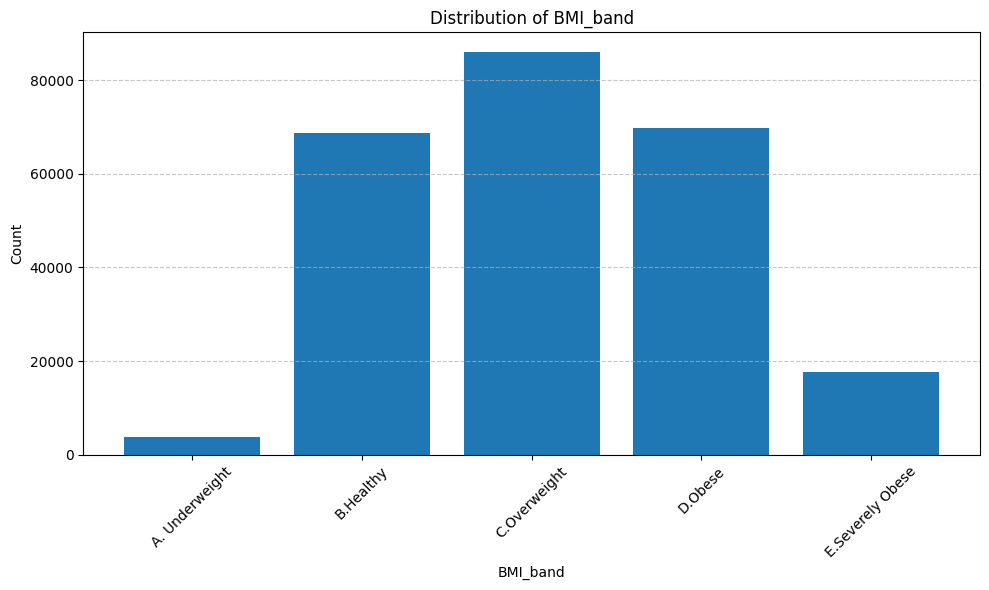

In [23]:
plotFunc(df, "BMI_band")

In [24]:
smoking_grp = df.groupBy("SmokerStatus", "HadHeartAttack").count()
smoking_total = smoking_grp.groupBy("SmokerStatus").agg(_sum("count").alias("total"))

smoking_percent = smoking_grp.join(smoking_total, on="SmokerStatus") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("SmokerStatus", "HadHeartAttack", "percentage") \
    .orderBy("SmokerStatus", "HadHeartAttack")

# Pivot
pivoted_smoking = smoking_percent.groupBy("HadHeartAttack") \
    .pivot("SmokerStatus") \
    .agg(_sum("percentage")) \
    .fillna(0)

# Add total row
smoking_cols = [c for c in pivoted_smoking.columns if c != "HadHeartAttack"]
smoking_total_row = pivoted_smoking.selectExpr(
    "'Total' as HadHeartAttack", *[f"round(sum(`{c}`), 2) as `{c}`" for c in smoking_cols]
)
smoking_final = pivoted_smoking.unionByName(smoking_total_row)
smoking_final.show()

+--------------+-------------------------------------+-------------------------------------+-------------+------------+
|HadHeartAttack|Current smoker - now smokes every day|Current smoker - now smokes some days|Former smoker|Never smoked|
+--------------+-------------------------------------+-------------------------------------+-------------+------------+
|            No|                                91.68|                                93.17|        91.81|        96.3|
|           Yes|                                 8.32|                                 6.83|         8.19|         3.7|
|         Total|                                100.0|                                100.0|        100.0|       100.0|
+--------------+-------------------------------------+-------------------------------------+-------------+------------+



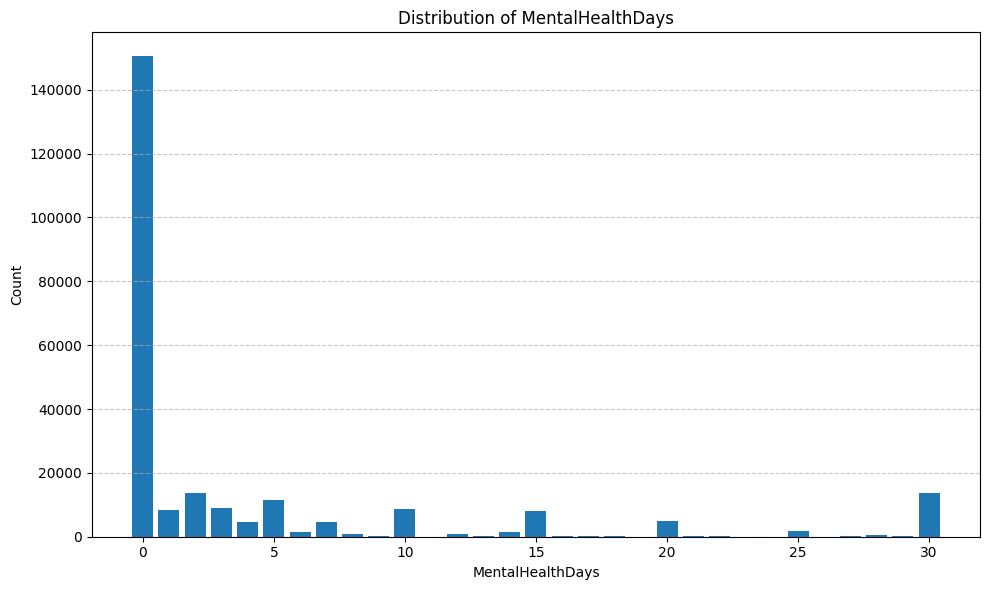

In [25]:
plotFunc(df, "MentalHealthDays")

In [26]:
# Question 8: Mental health days vs. heart disease
df_mental = df.withColumn(
    "MentalHealthBand",
    when(col("MentalHealthDays") == 0, "A.0 days")
    .when((col("MentalHealthDays") > 0) & (col("MentalHealthDays") <= 7), "B.1–7 days")
    .when((col("MentalHealthDays") > 7) & (col("MentalHealthDays") <= 14), "C.8–14 days")
    .otherwise("D.15–30 days")
)

mental_group = df_mental.groupBy("MentalHealthBand", "HadHeartAttack").count()
mental_total = mental_group.groupBy("MentalHealthBand").agg(_sum("count").alias("total"))

mental_percent = mental_group.join(mental_total, on="MentalHealthBand") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("MentalHealthBand", "HadHeartAttack", "percentage")

pivot_mental = mental_percent.groupBy("HadHeartAttack").pivot("MentalHealthBand").agg(_sum("percentage")).fillna(0)
mental_cols = [c for c in pivot_mental.columns if c != "HadHeartAttack"]
mental_total_row = pivot_mental.selectExpr(
    "'Total' as HadHeartAttack",
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in mental_cols]
)
final_mental_result = pivot_mental.unionByName(mental_total_row)
final_mental_result.show()

+--------------+--------+----------+-----------+------------+
|HadHeartAttack|A.0 days|B.1–7 days|C.8–14 days|D.15–30 days|
+--------------+--------+----------+-----------+------------+
|            No|   94.28|     96.15|      95.12|       92.78|
|           Yes|    5.72|      3.85|       4.88|        7.22|
|         Total|   100.0|     100.0|      100.0|       100.0|
+--------------+--------+----------+-----------+------------+



In [27]:
# Question 8: Mental health days vs. heart disease
df_mental = df.withColumn(
    "MentalHealthBand",
    when(col("MentalHealthDays") == 0, "A.0 days")
    .when((col("MentalHealthDays") > 0) & (col("MentalHealthDays") <= 7), "B.1–7 days")
    .when((col("MentalHealthDays") > 7) & (col("MentalHealthDays") <= 14), "C.8–14 days")
    .otherwise("D.15–30 days")
)

mental_group = df_mental.groupBy("MentalHealthBand", "HadDepressiveDisorder").count()
mental_total = mental_group.groupBy("MentalHealthBand").agg(_sum("count").alias("total"))

mental_percent = mental_group.join(mental_total, on="MentalHealthBand") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("MentalHealthBand", "HadDepressiveDisorder", "percentage")

pivot_mental = mental_percent.groupBy("HadDepressiveDisorder").pivot("MentalHealthBand").agg(_sum("percentage")).fillna(0)
mental_cols = [c for c in pivot_mental.columns if c != "HadDepressiveDisorder"]
mental_total_row = pivot_mental.selectExpr(
    "'Total' as HadDepressiveDisorder",
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in mental_cols]
)
final_mental_result = pivot_mental.unionByName(mental_total_row)
final_mental_result.show()

+---------------------+--------+----------+-----------+------------+
|HadDepressiveDisorder|A.0 days|B.1–7 days|C.8–14 days|D.15–30 days|
+---------------------+--------+----------+-----------+------------+
|                   No|   91.86|     72.37|      55.64|       39.69|
|                  Yes|    8.14|     27.63|      44.36|       60.31|
|                Total|   100.0|     100.0|      100.0|       100.0|
+---------------------+--------+----------+-----------+------------+



In [28]:
#of those who reported having depressive disorder and have taken over 8 mental health days

In [29]:
# Question 8: Mental health days vs. general health
# Recreate the df_banded with sleep_band as it was overwritten
df_with_sleep_band = df.withColumn(
    "sleep_band",
    when(col("SleepHours") < 7, "A.<7 hrs")
    .when((col("SleepHours") >= 7) & (col("SleepHours") < 9), "B.7-9 hrs")
    .when((col("SleepHours") >= 9) & (col("SleepHours") < 12), "C.9-12 hrs")
    .otherwise("D.>12 hrs")
)
# Group by GeneralHealth and sleep_band
health_group = df_with_sleep_band.groupBy("GeneralHealth", "sleep_band").count()

# Compute total per GeneralHealth category
health_total = health_group.groupBy("GeneralHealth").agg(_sum("count").alias("total"))

# Calculate percentages within each GeneralHealth group
health_percent = health_group.join(health_total, on="GeneralHealth") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("GeneralHealth", "sleep_band", "percentage")

# Pivot: rows = sleep_band, columns = GeneralHealth
pivot_rotated = health_percent.groupBy("sleep_band").pivot("GeneralHealth").agg(_sum("percentage")).fillna(0)

# Add total row
health_cols = [c for c in pivot_rotated.columns if c != "sleep_band"]
rotated_total_row = pivot_rotated.selectExpr(
    "'Total' as sleep_band",
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in health_cols]
)

final_rotated_result = pivot_rotated.unionByName(rotated_total_row).orderBy("sleep_band")

# Show rotated pivot
final_rotated_result.show()


+----------+---------+-----+-----+-----+---------+
|sleep_band|Excellent| Fair| Good| Poor|Very good|
+----------+---------+-----+-----+-----+---------+
|  A.<7 hrs|    25.03| 43.5|34.83| 50.1|    28.02|
| B.7-9 hrs|    67.85|45.22|57.21|34.27|     65.3|
|C.9-12 hrs|     6.63| 9.31|  7.2|11.08|     6.26|
| D.>12 hrs|     0.48| 1.97| 0.76| 4.55|     0.42|
|     Total|    99.99|100.0|100.0|100.0|    100.0|
+----------+---------+-----+-----+-----+---------+



In [30]:
cardio_cols = ["HadHeartAttack", "HadAngina", "HadStroke"]
cardio_tables = []

for col_name in cardio_cols:
    # Group by AgeCategory and condition
    group = df.groupBy("AgeCategory", col_name).count()

    # Total per condition value (Yes/No)
    total = group.groupBy(col_name).agg(_sum("count").alias("total"))

    # Percentage per condition value
    percent = group.join(total, on=col_name) \
        .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
        .filter(col(col_name) == "Yes") \
        .select("AgeCategory", "percentage") \
        .withColumnRenamed("percentage", col_name)

    cardio_tables.append(percent)

# Join all percentage columns on AgeCategory
from functools import reduce
from pyspark.sql import DataFrame

final_cardio = reduce(
    lambda df1, df2: df1.join(df2, on="AgeCategory", how="outer"),
    cardio_tables
).fillna(0)

# Add total row (column-wise sum of percentages)
cardio_condition_cols = [c for c in final_cardio.columns if c != "AgeCategory"]
total_row = final_cardio.selectExpr(
    "'Total' as AgeCategory",
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in cardio_condition_cols]
)

final_cardio_result = final_cardio.unionByName(total_row)

# Show result
final_cardio_result.show()


+---------------+--------------+---------+---------+
|    AgeCategory|HadHeartAttack|HadAngina|HadStroke|
+---------------+--------------+---------+---------+
|   Age 18 to 24|          0.37|     0.33|      0.5|
|   Age 25 to 29|          0.35|     0.38|      0.6|
|   Age 30 to 34|          0.67|     0.48|     1.04|
|   Age 35 to 39|          1.16|      0.8|     1.78|
|   Age 40 to 44|           1.7|     1.29|     2.51|
|   Age 45 to 49|          3.13|     2.33|     3.71|
|   Age 50 to 54|          5.23|     4.26|      6.2|
|   Age 55 to 59|          8.28|     7.14|     8.62|
|   Age 60 to 64|         11.72|    11.32|    12.45|
|   Age 65 to 69|         16.04|    16.31|     14.9|
|   Age 70 to 74|         17.92|    19.03|    16.44|
|   Age 75 to 79|         15.37|    16.89|    13.79|
|Age 80 or older|         18.06|    19.43|    17.45|
|          Total|         100.0|    99.99|    99.99|
+---------------+--------------+---------+---------+



In [31]:
# Step 1: Filter people with Angina
angina_df = df.filter(col("HadAngina") == "Yes")
angina_df = angina_df.withColumn(
    "sleep_band",
    when(col("SleepHours") < 7, "A.<7 hrs")
    .when((col("SleepHours") >= 7) & (col("SleepHours") < 9), "B.7-9 hrs")
    .when((col("SleepHours") >= 9) & (col("SleepHours") < 12), "C.9-12 hrs")
    .otherwise("D.>12 hrs")
)
# Group by HadDepressiveDisorder and Sex
health_group = angina_df.groupBy("HadDepressiveDisorder", "Sex").count()

# Compute total per HadDepressiveDisorder category
health_total = health_group.groupBy("HadDepressiveDisorder").agg(_sum("count").alias("total"))

# Calculate percentages within each HadDepressiveDisorder group
health_percent = health_group.join(health_total, on="HadDepressiveDisorder") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("HadDepressiveDisorder", "Sex", "percentage")

# Pivot: rows = Sex, columns = HadDepressiveDisorder
pivot_rotated = health_percent.groupBy("Sex").pivot("HadDepressiveDisorder").agg(_sum("percentage")).fillna(0)

# Add total row
health_cols = [c for c in pivot_rotated.columns if c not in ["Sex", "HadDepressiveDisorder"]]

rotated_total_row = pivot_rotated.selectExpr(
    "'Total' as Sex",
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in health_cols]
)

final_rotated_result = pivot_rotated.unionByName(rotated_total_row).orderBy("Sex")

# Show rotated pivot
final_rotated_result.show()

from pyspark.sql.functions import col, round, sum as _sum

# Step 1: Filter people with Angina
angina_df = df.filter(col("HadAngina") == "No")
angina_df = angina_df.withColumn(
    "sleep_band",
    when(col("SleepHours") < 7, "A.<7 hrs")
    .when((col("SleepHours") >= 7) & (col("SleepHours") < 9), "B.7-9 hrs")
    .when((col("SleepHours") >= 9) & (col("SleepHours") < 12), "C.9-12 hrs")
    .otherwise("D.>12 hrs")
)
# Group by HadDepressiveDisorder and Sex
health_group = angina_df.groupBy("HadDepressiveDisorder", "Sex").count()

# Compute total per HadDepressiveDisorder category
health_total = health_group.groupBy("HadDepressiveDisorder").agg(_sum("count").alias("total"))

# Calculate percentages within each HadDepressiveDisorder group
health_percent = health_group.join(health_total, on="HadDepressiveDisorder") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("HadDepressiveDisorder", "Sex", "percentage")

# Pivot: rows = Sex, columns = HadDepressiveDisorder
pivot_rotated = health_percent.groupBy("Sex").pivot("HadDepressiveDisorder").agg(_sum("percentage")).fillna(0)

# Add total row
health_cols = [c for c in pivot_rotated.columns if c not in ["Sex", "HadDepressiveDisorder"]]

rotated_total_row = pivot_rotated.selectExpr(
    "'Total' as Sex",
    *[f"round(sum(`{c}`), 2) as `{c}`" for c in health_cols]
)

final_rotated_result = pivot_rotated.unionByName(rotated_total_row).orderBy("Sex")

# Show rotated pivot
final_rotated_result.show()

+------+-----+-----+
|   Sex|   No|  Yes|
+------+-----+-----+
|Female|34.19|53.62|
|  Male|65.81|46.38|
| Total|100.0|100.0|
+------+-----+-----+

+------+-----+-----+
|   Sex|   No|  Yes|
+------+-----+-----+
|Female|49.17|66.99|
|  Male|50.83|33.01|
| Total|100.0|100.0|
+------+-----+-----+



In [32]:
# Step 1: Group by State and HadDepressiveDisorder
states_group = df.groupBy("State", "HadDepressiveDisorder").count()

# Step 2: Compute total counts per state
states_total = states_group.groupBy("State").agg(_sum("count").alias("total"))

# Step 3: Join and calculate percentages within each state
states_percent = states_group.join(states_total, on="State") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("State", "HadDepressiveDisorder", "percentage")

# Step 4: Pivot so each state is a row and columns = Yes/No
pivoted = states_percent.groupBy("State").pivot("HadDepressiveDisorder").agg(_sum("percentage")).fillna(0)

# Step 5: Add total column to validate row-wise 100%
final_result = pivoted

# Step 6: Show results sorted by % of 'Yes'
final_result.orderBy(col("Yes").desc()).show()


+--------------+-----+-----+
|         State|   No|  Yes|
+--------------+-----+-----+
|     Tennessee|72.77|27.23|
| West Virginia|73.71|26.29|
|      Oklahoma|75.01|24.99|
|      Kentucky|75.34|24.66|
|      Arkansas|75.41|24.59|
|        Oregon|75.47|24.53|
|    Washington|76.02|23.98|
|     Louisiana|76.11|23.89|
|          Ohio|76.35|23.65|
|     Minnesota|76.47|23.53|
|       Vermont|76.64|23.36|
|          Utah|76.74|23.26|
|North Carolina|77.34|22.66|
|         Maine|78.03|21.97|
|      Colorado| 78.1| 21.9|
| Massachusetts|78.17|21.83|
|      Michigan|78.36|21.64|
|  Rhode Island|78.37|21.63|
|   Connecticut|78.53|21.47|
|       Indiana|78.66|21.34|
+--------------+-----+-----+
only showing top 20 rows



In [33]:
# Step 1: Count how many people in each health category per state
health_group = df.groupBy("State", "GeneralHealth").count()

# Step 2: Total people per state
state_totals = health_group.groupBy("State").agg(_sum("count").alias("total"))

# Step 3: Calculate % per health category within each state
health_percent = health_group.join(state_totals, on="State") \
    .withColumn("percentage", round((col("count") / col("total")) * 100, 2)) \
    .select("State", "GeneralHealth", "percentage")

# Step 4: Pivot to make states rows and health levels columns
pivoted_health = health_percent.groupBy("State") \
    .pivot("GeneralHealth", ["Excellent", "Very good", "Good", "Fair", "Poor"]) \
    .agg(_sum("percentage")) \
    .fillna(0)

# Step 5: Add row-wise total to verify percentages
final_health_table = pivoted_health.withColumn(
    "Total", round(sum(col(c) for c in pivoted_health.columns if c != "State"), 2)
)

# Step 6: Sort by % Excellent if desired
final_health_table.orderBy(col("Excellent").desc()).show()


+--------------------+---------+---------+-----+-----+----+------+
|               State|Excellent|Very good| Good| Fair|Poor| Total|
+--------------------+---------+---------+-----+-----+----+------+
|District of Columbia|    24.29|    37.16|27.01| 9.45|2.09| 100.0|
|       Massachusetts|    21.34|    37.77|28.47|10.14|2.29|100.01|
|          New Jersey|    20.39|    37.38|28.46|10.86| 2.9| 99.99|
|         Connecticut|    20.36|    37.62|28.85| 9.93|3.23| 99.99|
|             Vermont|    20.29|    40.91|27.47| 8.46|2.87| 100.0|
|            Colorado|    20.22|    38.38|28.98| 9.87|2.56|100.01|
|                Utah|    20.17|    35.86| 30.3| 10.4|3.26| 99.99|
|        Rhode Island|    19.51|    35.48|29.95|12.11|2.96|100.01|
|          California|    19.47|    34.52|29.98|12.26|3.77| 100.0|
|      North Carolina|    19.44|    35.87|28.54|12.15| 4.0| 100.0|
|         Puerto Rico|    19.36|     16.1|34.55|26.19|3.79| 99.99|
|              Hawaii|    18.71|    32.18|34.02|11.49|3.59| 99